<a href="https://colab.research.google.com/github/tobytoyin/sec-10q-msc-report/blob/main/3_Build_Word_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
This notebook is used for creating BoW features, including TF-IDF matrix, LDA matrix, sentiment word counts.

# File Directories

In [ ]:
# !pip install scipy --upgrade

In [ ]:
%cd '/content/drive/MyDrive/Aston/Term 3/ML-training'
# !python -m spacy download en_core_web_lg

import nltk
import string
import re
import random 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
import json
import os
nltk.download('stopwords')
nltk.download('punkt')

from scipy.sparse import csr_matrix
from scipy.stats import ttest_1samp
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from utils.file_loader import include_stopwords
from utils.bow_features_extraction import ExtendCountVectorizer, TokenierPipeline, filter_p_value_tokens
from train.components.pipeline_components import *
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


SEED = 13579
random.seed(SEED)

train_dir = '/content/drive/MyDrive/Aston/Term 3/ML-training'
which_base = 'base_sel'
datasets = 'datasets'
dir_json = 'dir_map.json'

# setup datapaths 
with open(f'{train_dir}/{dir_json}', 'r') as f:
  datapaths = json.load(f)

datapaths.keys()

/content/drive/MyDrive/Aston/Term 3/ML-training
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


dict_keys(['doc_word_counts', 'sentiment_percent', 'lsa100_lg', 'lsa200_lg', 'doc_word_counts_lg', 'explore_sentiment_count_lg', 'sentiment_percent_lg', 'unigram_tf_lg', 'bigram_tf_lg', 'bigram_lsa100_lg', 'bigram_lsa200_lg', 'unigram_lda40_lg', 'unigram_lsa100_lg', 'unigram_lsa200_lg', 'unigram_selectedLda_lg', 'base', 'bigram_lsa300_lg', 'unigram_lda30_lg', 'unigram_selectedLda30_lg', 'base_sel', 'np_tf_lg', 'np_lsa100_lg', 'np_lsa200_lg', 'base_sel2', 'bigram_lda30_lg', 'bigram_selectedLda30_lg'])

In [ ]:
# load the training data and test data 
train_set = pd.read_csv(datapaths[which_base]['train'], index_col=0)
test_set = pd.read_csv(datapaths[which_base]['test'], index_col=0)

def save_to_path(train_df, test_df, filename, key):
  global datapaths
  global train_set
  global test_set 

  # simple validate 
  assert train_df.shape != test_df.shape, "Same Data Source"
  assert train_df.shape[1] == test_df.shape[1], "Features are not the same"

  train_df.index = train_set.index
  test_df.index = test_set.index

  train_savename = f'{train_dir}/{datasets}/train_' + filename
  test_savename = f'{train_dir}/{datasets}/test_' + filename

  train_df.to_csv(train_savename)
  test_df.to_csv(test_savename)

  datapaths[key] = {
      'feature_names': list(train_df.columns), 
      'train': train_savename, 
      'test': test_savename
  }

  with open(f'{train_dir}/{dir_json}', 'w') as f:
    json.dump(datapaths, f)

## Print Data Shape ## 
print("[TRAIN] Shape: ", train_set.shape)
print("[TEST]  Shape: ", test_set.shape)

[TRAIN] Shape:  (8744, 85)
[TEST]  Shape:  (2291, 85)


In [ ]:
# create stopwords 
# retrive the stopword txt
txt_list = os.listdir('datasets/edgar_stopwords')
lm_stopwords = []

for txt in txt_list:
  with open(os.path.join('datasets/edgar_stopwords', txt), 'r', errors='ignore') as f:
    # read stopwords 
    print(txt)
    stopwords = f.readlines()

    # replace '|' comments, and remove end of lines
    stopwords = map(lambda x: x.split('|')[0], stopwords)
    stopwords = map(lambda x: x.strip().lower().replace('\n', ''), stopwords)
    lm_stopwords += list(stopwords)

StopWords_Generic.txt
StopWords_Auditor.txt
StopWords_Currencies.txt
StopWords_GenericLong.txt
StopWords_Geographic.txt
StopWords_Names.txt
StopWords_DatesandNumbers.txt


## Tokenizer 
We first define our tokenizer and preprocessing step

In [ ]:
# some modifier stopwords are useful in bigrams tokens
# and add some punctuation in the stopwords
lm_stopwords.extend([*string.punctuation, "'s"])
lm_stopwords = set(lm_stopwords).difference(include_stopwords)

# set up Porter stemmer 
porter_stemmer = PorterStemmer().stem

# put all the items into a single Pipeline
tokenizer = TokenierPipeline(tokenizer=word_tokenize, 
                             stemmer=porter_stemmer, 
                             stop_words=lm_stopwords)

# add regex 
tokenizer.add_re_filter(r'\d*([\,\.]\d*)*$')
tokenizer.add_re_filter(r'([a-zA-Z0-9]{1,2}[\/\-\+]{1,2}\d?)*$')  # numerical sequences 
tokenizer.add_re_filter(r'^\d*[a-zA-Z]$')  # indicating another sections
tokenizer.add_re_filter(r'.*(www\.|https?:|www).*')  # websites
tokenizer.add_re_filter(r'^\w$')  # single character
tokenizer.add_re_filter(r'^\\[ux]\d*')  # non-unicode
tokenizer.add_re_filter('^[`\'\$]*$') # some empty string symbols
tokenizer.add_re_filter('^(?![a-zA-Z\"\']).*') # starting with symbol
tokenizer.add_re_filter("[^a-zA-Z.!?']")  # non letters

# add sub-word breakdown
tokenizer.add_re_breakwords(symbol='-/~+_')

## Sentiment Word Dictionaries
In this section, I load the LM Sentiment Word List. First, the each words are preprocess by Porter Stemmer and each word are stored in a respective section in the dictionary. We will use those stemmed vocabularies to create `CountVectorizer` representing each sentiment.

In [ ]:
# load sentiment word dictionary
sentiment_types = ['Negative', 'Positive', 'Uncertainty', 'Litigious', 'StrongModal', 'WeakModal', 'Constraining']
sentiment_vectorizers = {}
sentiment_vocabs_all = []

for sentiment in sentiment_types:
  # load the sentiment dictionary 
  df = pd.read_excel('datasets/dictionary/lm_sentiment.xlsx', sheet_name=sentiment, names=['word'])

  # convert to list 
  word_list = df['word'].tolist()

  # stem the vocab 
  sentiment_vocabs = list(map(lambda tok: tok.lower(), word_list))
  sentiment_vocabs_all += sentiment_vocabs

  # creating countvectorizer for sentiment vocabs
  sentiment_tf = CountVectorizer(
      vocabulary=sentiment_vocabs, 
      strip_accents='unicode',
      analyzer='word',  
      stop_words=None
      )
  
  sentiment_vectorizers[sentiment] = sentiment_tf


sentiment_vocabs_set = set(map(porter_stemmer, sentiment_vocabs_all))
print(len(sentiment_vocabs_set))

1608


To produce the number of words in each sentiment, we fit and transform our courpus. Then sum the total of number of words of that sentiment.

In [ ]:
train_sentiment_counts = pd.DataFrame()
test_sentiment_counts = pd.DataFrame()

for sentiment in sentiment_types:
  # fit and transform corpus for train
  train_term_freq = sentiment_vectorizers[sentiment].fit_transform(train_set['10-q-text'])
  test_term_freq = sentiment_vectorizers[sentiment].transform(test_set['10-q-text'])

  # then some the total of the term frequency
  train_sentiment_counts[sentiment] = csr_matrix.sum(train_term_freq, axis=1).squeeze().tolist()[0]
  test_sentiment_counts[sentiment] = csr_matrix.sum(test_term_freq, axis=1).squeeze().tolist()[0]

Now get the length of the sentences

In [ ]:
train_doc_word_counts = pd.DataFrame({'word_counts': train_set['10-q-text'].str.split(' ').apply(len)})
test_doc_word_counts = pd.DataFrame({'word_counts': test_set['10-q-text'].str.split(' ').apply(len)})

# save_to_path(train_doc_word_counts, test_doc_word_counts, 'doc_word_counts_lg.csv', 'doc_word_counts_lg')
train_doc_word_counts.head()

word_counts
9          9301
10         8806
11         7546
12        12221
13        11385

In [ ]:
train_sentiment_percent = train_sentiment_counts / train_doc_word_counts.values * 100
train_sentiment_percent.columns = train_sentiment_percent.columns + '_percent'

test_sentiment_percent = test_sentiment_counts / test_doc_word_counts.values * 100
test_sentiment_percent.columns = test_sentiment_percent.columns + '_percent'

# save_to_path(train_sentiment_percent, test_sentiment_percent, 'raw_sentiment_percent_lg.csv', 'raw_sentiment_percent_lg')

from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
train_sentiment_percent = pd.DataFrame(scaler.fit_transform(train_sentiment_percent), 
                                       index=train_sentiment_percent.index, 
                                       columns=train_sentiment_percent.columns)

test_sentiment_percent = pd.DataFrame(scaler.fit_transform(test_sentiment_percent), 
                                       index=test_sentiment_percent.index, 
                                       columns=test_sentiment_percent.columns)

# save the counts as exploration analysis
save_to_path(train_sentiment_counts, test_sentiment_counts, 'explore_sentiment_count_lg.csv', 'explore_sentiment_count_lg')

# save the percentage as input features
save_to_path(train_sentiment_percent, test_sentiment_percent, 'sentiment_percent_lg.csv', 'sentiment_percent_lg')
train_sentiment_percent.head()

NameError: ignored

# Unigram Term Frequency

In this section, we will create unigram features. Below are some of the features:
1. Treebank Tokenizer (`word_tokenize`): treat each punctuation as unique token and split text will punctuation into multiple tokens  
2. Porter Stemmer: Stem similar words into an root form  
3. Loughran & McDonald Stopwords
4. Max_df = 0.8 to filter out tokens that appear in 80% of the training documents

In [ ]:
# fit a unigram term frequency
unigram_tf = ExtendCountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word', 
  stop_words=None, 
  ngram_range=(1, 1), 
  max_df=0.7,
)

text_data = unigram_tf.fit_transform(train_set['10-q-text'])

## Removing Infrequent Words 
We will remove terms that have less than 15 frequency

In [ ]:
def infrequent_removal(countvectorizer, text_data, infreq=15):
  """Helper function to get the infrequent terms from a CountVectorizer
  """
  term_freq = countvectorizer.term_frequency(text_data)

  # filter terms that are 15 or less
  infreq_terms = list(term_freq[term_freq['freq'] <= infreq].index)
  print(f"Examples of infrequent Tokens: {random.sample(infreq_terms, 10)}")
  print(f"Number of infrequent Tokens  : ", len(infreq_terms))
  return infreq_terms

In [ ]:
# retrieve term frequency
infreq_terms = infrequent_removal(unigram_tf, text_data, 15)

Examples of infrequent Tokens: ['familytalk', 'alychlo', 'couck', 'ridien', 'smuggler', 'causeway', 'multifactor', 'ficant', 'ommerci', 'globalview']
Number of infrequent Tokens  :  14548


## Chi<sup>2</sup> Feature Selection
We will do feature selection on the term frequency using Chi<sup>2</sup> Feature Selection. This method requires the target variables to be a binary class. Consider that the mean return is near 1% and most literatures used 1% as UP and DOWN cutting point. We select out words that have more than 1% abnormal stock returns influence.

In [ ]:
def chi2_feature_selection(countvectorizer, text_data, target, p_val=0.05):
  chi, p = chi2(text_data, target)
  print(f"Number of Tokens in Sparse Matrix: {len(p)}.")
  print(f"Number of Tokens that have less than 1% return influence {sum(p > p_val)}")

  # filter words 
  sel_indices = np.where(p > p_val)[0]
  vocabs_list = list(countvectorizer.get_vocabs().keys())
  remove_words = [vocabs_list[i] for i in sel_indices]
  print(f"Example of Weak Importance Tokens: {random.sample(remove_words, 10)}")
  print(f"Number of Weak Importance Tokens {len(remove_words)}")
  return remove_words 

In [ ]:
## Perform Chi2 Feature Selection ## 
# set up labels if increase more than 1%
gt_1_pct = abs(train_set['y_return30_nom']) >= 0.01
chi2_remove_tokens = chi2_feature_selection(unigram_tf, text_data, gt_1_pct)

Number of Tokens in Sparse Matrix: 26241.
Number of Tokens that have less than 1% return influence 20698
Example of Weak Importance Tokens: ['tokraft', 'sunvepra', 'postproduct', 'ction', 'cdp323', 'lit', 'dior', 'unrecoup', 'caviar', 'central']
Number of Weak Importance Tokens 20698


After getting the infrequent words and the lower return words. We will also include the mcDonald sentiment word list into our vocabulary.

## TF-IDF and LSA
Now we will convert the text into TF-IDF matrix and conduct Latent Sematic Analysis. We will first: 
1. Convert Sentiment Words into stemmed vocabularies 
2. Gather the words to be ignored (infrequent terms & weak influnece terms)
3. Build the vocabulary by adding (1) and minus (2)
4. Create `TfidfVectorizer` using the vocabularies in (3)

For the LSA, we will examine the number of vectors that gives as high variation ratio. We will: 
1. Create a 500 SVD components 
2. Examine the points with strongest increase in explained variation 


In [ ]:
# preprocess the LM Sentiment words by stemmer 
sentiment_vocabs_set = set(map(porter_stemmer, sentiment_vocabs_all))

# get the filter out words 
filter_words = set(infreq_terms + chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
unigram_vocabs = set(unigram_tf.vocabulary_.keys())
unigram_vocabs = unigram_vocabs.difference(filter_words)
unigram_vocabs.update(sentiment_vocabs_set)
print("[TOKENS] ", len(unigram_vocabs))

# using the filtered vocabs to fit a Tfidf Vectorizer
unigram_countvectorizer = CountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(1, 1), 
  max_df=0.7,
  vocabulary=unigram_vocabs
)

# fit the count vectorizer 
unigram_train_term_freq = unigram_countvectorizer.fit_transform(train_set['10-q-text'])
unigram_test_term_freq = unigram_countvectorizer.transform(test_set['10-q-text'])

unigram_train_tf_df = pd.DataFrame(unigram_train_term_freq.toarray(), columns=unigram_countvectorizer.vocabulary_)
unigram_test_tf_df = pd.DataFrame(unigram_test_term_freq.toarray(), columns=unigram_countvectorizer.vocabulary_)
print("[TRAIN] ", unigram_train_tf_df.shape)
print("[TEST]  ", unigram_test_tf_df.shape)
save_to_path(unigram_train_tf_df, unigram_test_tf_df, 'unigram_tf_lg.csv', 'unigram_tf_lg')

[TOKENS]  5397
[TRAIN]  (8242, 5397)
[TEST]   (2291, 5397)


In [ ]:
# plot the data
def plot_lsa_explain_ratio(tf_data, max_components=500):
  tfidf_data = TfidfTransformer().fit_transform(tf_data)
  svd = TruncatedSVD(n_components=max_components, random_state=SEED)
  lsa = svd.fit_transform(tfidf_data)

  # cum_explained_var_ratios = np.cumsum(svd.explained_variance_ratio_)
  df = pd.DataFrame({
    'cum_explained_var_ratio': np.cumsum(svd.explained_variance_ratio_),
    'components': range(1, max_components + 1)
  })
  g = sns.lineplot(data=df, y='cum_explained_var_ratio', x='components')

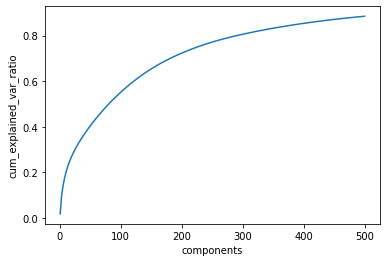

In [ ]:
plot_lsa_explain_ratio(unigram_train_term_freq)
plt.savefig(f'{train_dir}/eda_images/unigram_lsa_explainedRatio.png', transparent=False)

## Create LSA Features 
With 100, 200 LSA matrix. It explained about 80% variation of the BoW. It is similar to previous literature, reducing TF-IDF matrix to 200 dimension. We will save the TF-IDF as our input features. This could reduce our pipeline complexity during training. 

In [ ]:
## create pipeline for LSA output ## 
lsa100_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=200, random_state=SEED, n_iter=100))                      
])

lsa200_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=300, random_state=SEED, n_iter=100))                      
])

## fit the training and test data
train_lsa100 = lsa100_pipeline.fit_transform(unigram_train_term_freq)
test_lsa100 = lsa100_pipeline.transform(unigram_test_term_freq)

train_lsa200 = lsa200_pipeline.fit_transform(unigram_train_term_freq)
test_lsa200 = lsa200_pipeline.transform(unigram_test_term_freq)

In [ ]:
# save to csv
lsa100_columns = [f'lsa_{i}' for i in range(1, 201)]
train_lsa100_df = pd.DataFrame(train_lsa100, columns=lsa100_columns)
test_lsa100_df = pd.DataFrame(test_lsa100, columns=lsa100_columns)
print("[TRAIN] ", train_lsa100_df.shape)
print("[TEST]  ", test_lsa100_df.shape)
save_to_path(train_lsa100_df, test_lsa100_df, 'unigram_lsa200_lg.csv', 'unigram_lsa200_lg')


lsa200_columns = [f'lsa_{i}' for i in range(1, 301)]
train_lsa200_df = pd.DataFrame(train_lsa200, columns=lsa200_columns)
test_lsa200_df = pd.DataFrame(test_lsa200, columns=lsa200_columns)
print("[TRAIN] ", train_lsa200_df.shape)
print("[TEST]  ", test_lsa200_df.shape)
save_to_path(train_lsa200_df, test_lsa200_df, 'unigram_lsa300_lg.csv', 'unigram_lsa300_lg')

[TRAIN]  (8242, 200)
[TEST]   (2291, 200)
[TRAIN]  (8242, 300)
[TEST]   (2291, 300)


# Bigram Term Frequency
Next we will create bigram term frequency

In [ ]:
# fit a bigram term frequency
bigram_tf = ExtendCountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(2, 2), 
  max_df=0.8, 
)

bi_text_data = bigram_tf.fit_transform(train_set['10-q-text'])
print(len(bigram_tf.vocabulary_))
print('done')

1069402
done


In [ ]:
# retrieve term frequency
# bi_infreq_terms = infrequent_removal(bigram_tf, bi_text_data, 15)
matrix_terms = np.array(bigram_tf.get_feature_names())
matrix_freq = np.asarray(bi_text_data.sum(axis=0)).ravel()
term_freq = dict(zip(matrix_terms, matrix_freq))

# find terms that have <= 15 frequency
bi_infreq_terms = [key for key, val in term_freq.items() if val <= 10]
print("Infrequent Tokens Count: ", len(bi_infreq_terms))
print("Examples: ", random.sample(bi_infreq_terms, 10))

Infrequent Tokens Count:  780703
Examples:  ['level contra', 'therapeut judgment', 'address ir', 'charg knowledg', 'ipl infrastructur', 'detail restrict', 'critic problem', 'phlebotomist increas', 'u.s. gdss', 'improv homebuy']


In [ ]:
from sklearn.feature_selection import SelectKBest

## Perform Chi2 Feature Selection ## 
# set up labels if increase more than 1%
gt_1_pct = abs(train_set['y_return30_nom']) >= 0.01

chi2_kbest = SelectKBest(chi2, k=6000)
kbest = chi2_kbest.fit_transform(bi_text_data, gt_1_pct)

kbest_bool = chi2_kbest.get_support()
vocabs_list = dict(zip(bigram_tf.get_vocabs().keys(), kbest_bool))
bi_chi2_remove_tokens = [key for key, val in vocabs_list.items() if val == False]
print("Low Chi2 Tokens Count: ", len(bi_chi2_remove_tokens))
print("Examples: ", random.sample(bi_chi2_remove_tokens, 10))



# gt_1_pct = abs(train_set['y_return30_nom']) >= 0.01
# bi_chi2_remove_tokens = chi2_feature_selection(bigram_tf, bi_text_data, gt_1_pct)

Low Chi2 Tokens Count:  1063402
Examples:  ['compon u.s.', 'resiz fiscal', 'expir competit', 'financ util', 'improv monitor', 'elig rescu', 'cocreat pay', 'stent relat', 'face energi', 'forgav provid']


## LSA for Bigram
Similarly we will conduct the same setup as in our unigram.

In [ ]:
# preprocess the LM Sentiment words by stemmer 
sentiment_vocabs_set = set(map(porter_stemmer, sentiment_vocabs_all))

# get the filter out words 
filter_words = set(bi_infreq_terms + bi_chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
bigram_vocabs = set(bigram_tf.vocabulary_.keys())
bigram_vocabs = bigram_vocabs.difference(filter_words)
# bigram_vocabs.update(sentiment_vocabs_set)
print("[TOKENS] ", len(bigram_vocabs))

# using the filtered vocabs to fit a Tfidf Vectorizer
bigram_countvectorizer = CountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(2, 2), 
  max_df=0.7,
  vocabulary=bigram_vocabs
)


# fit the count vectorizer 
bigram_train_term_freq = bigram_countvectorizer.fit_transform(train_set['10-q-text'])
bigram_test_term_freq = bigram_countvectorizer.transform(test_set['10-q-text'])

bigram_train_tf_df = pd.DataFrame(bigram_train_term_freq.toarray(), columns=bigram_countvectorizer.vocabulary_)
bigram_test_tf_df = pd.DataFrame(bigram_test_term_freq.toarray(), columns=bigram_countvectorizer.vocabulary_)
print("[TRAIN] ", bigram_train_tf_df.shape)
print("[TEST]  ", bigram_test_tf_df.shape)
save_to_path(bigram_train_tf_df, bigram_test_tf_df, 'bigram_tf_lg.csv', 'bigram_tf_lg')

[TOKENS]  3647
[TRAIN]  (8242, 3647)
[TEST]   (2291, 3647)


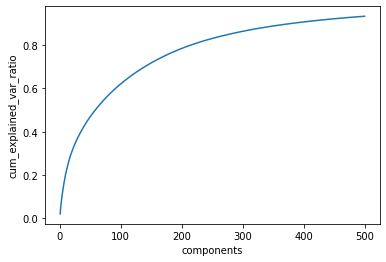

In [ ]:
plot_lsa_explain_ratio(bigram_train_term_freq)
plt.savefig(f'{train_dir}/eda_images/bigram_lsa_explainedRatio.png', transparent=False)

## Create LSA Bigram Features 


In [ ]:
## create pipeline for LSA output ## 
bi_lsa100_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=100, random_state=SEED, n_iter=100))                      
])

bi_lsa200_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=200, random_state=SEED, n_iter=100))                      
])

bi_lsa300_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=300, random_state=SEED, n_iter=100))                      
])

## fit the training and test data
train_bi_lsa100 = bi_lsa100_pipeline.fit_transform(bigram_train_term_freq)
test_bi_lsa100 = bi_lsa100_pipeline.transform(bigram_test_term_freq)

train_bi_lsa200 = bi_lsa200_pipeline.fit_transform(bigram_train_term_freq)
test_bi_lsa200 = bi_lsa200_pipeline.transform(bigram_test_term_freq)

train_bi_lsa300 = bi_lsa300_pipeline.fit_transform(bigram_train_term_freq)
test_bi_lsa300 = bi_lsa300_pipeline.transform(bigram_test_term_freq)

In [ ]:
# save to csv
lsa100_columns = [f'lsa_{i}' for i in range(1, 101)]
train_bi_lsa100_df = pd.DataFrame(train_bi_lsa100, columns=lsa100_columns)
test_bi_lsa100_df = pd.DataFrame(test_bi_lsa100, columns=lsa100_columns)
print("[TRAIN] ", train_bi_lsa100_df.shape)
print("[TEST]  ", test_bi_lsa100_df.shape)
save_to_path(train_bi_lsa100_df, test_bi_lsa100_df, 'bigram_lsa100_lg.csv', 'bigram_lsa100_lg')


lsa200_columns = [f'lsa_{i}' for i in range(1, 201)]
train_bi_lsa200_df = pd.DataFrame(train_bi_lsa200, columns=lsa200_columns)
test_bi_lsa200_df = pd.DataFrame(test_bi_lsa200, columns=lsa200_columns)
print("[TRAIN] ", train_bi_lsa200_df.shape)
print("[TEST]  ", test_bi_lsa200_df.shape)
save_to_path(train_bi_lsa200_df, test_bi_lsa200_df, 'bigram_lsa200_lg.csv', 'bigram_lsa200_lg')

lsa300_columns = [f'lsa_{i}' for i in range(1, 301)]
train_bi_lsa300_df = pd.DataFrame(train_bi_lsa300, columns=lsa300_columns)
test_bi_lsa300_df = pd.DataFrame(test_bi_lsa300, columns=lsa300_columns)
print("[TRAIN] ", train_bi_lsa300_df.shape)
print("[TEST]  ", test_bi_lsa300_df.shape)
save_to_path(train_bi_lsa300_df, test_bi_lsa300_df, 'bigram_lsa300_lg.csv', 'bigram_lsa300_lg')

[TRAIN]  (8242, 100)
[TEST]   (2291, 100)
[TRAIN]  (8242, 200)
[TEST]   (2291, 200)
[TRAIN]  (8242, 300)
[TEST]   (2291, 300)


# Latent Dirichlet Allocation
Next we will explore Latent Dirichlet Allocation (LDA). Previous research identified that financial filings and documents have about 30-40 latent topics. 

In [ ]:
# read the unigram data 
train_unigram_tf = pd.read_csv(datapaths['unigram_tf_lg']['train'], index_col=0)
test_unigram_tf = pd.read_csv(datapaths['unigram_tf_lg']['test'], index_col=0)
print("[TRAIN] : ", train_unigram_tf.shape)
print("[TEST]  : ", test_unigram_tf.shape)

[TRAIN] :  (8744, 5500)
[TEST]  :  (2291, 5500)


In [ ]:
## Create LDA Features 
def build_lda(k, n_gram_df):
  lda = LatentDirichletAllocation(n_components=k, random_state=13579,
                                  doc_topic_prior=50/k, 
                                  topic_word_prior=0.025, n_jobs=-1)

  lda.fit(n_gram_df)
  return lda

In [ ]:
# build lda 
k = 30
unigram_lda = build_lda(k=k, n_gram_df=train_unigram_tf)

train_unigram_lda_score = unigram_lda.transform(train_unigram_tf)
test_unigram_lda_score = unigram_lda.transform(test_unigram_tf)

In [ ]:
## Saving the topics matrix as features ##
columns_names = [f'topic_{i}' for i in range(1, k + 1)] 
train_unigram_topics = pd.DataFrame(train_unigram_lda_score, columns=columns_names)
test_unigram_topics = pd.DataFrame(test_unigram_lda_score, columns=columns_names)
print("[TRAIN]: ", train_unigram_topics.shape)
print("[TEST ]: ", test_unigram_topics.shape)
save_to_path(train_unigram_topics, test_unigram_topics, f'unigram_lda{k}_lg.csv', f'unigram_lda{k}_lg')

[TRAIN]:  (8744, 30)
[TEST ]:  (2291, 30)


## Topic 20 words of Topics
Now we will examine the top 20 words of the features.

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
  k  = model.n_components
  fig, axes = plt.subplots(int(k/5), 5, figsize=(20, 70), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
      top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
      top_features = [feature_names[i] for i in top_features_ind]
      weights = topic[top_features_ind]

      ax = axes[topic_idx]
      ax.barh(top_features, weights, height=0.7)
      ax.set_title(f'Topic {topic_idx +1}',
                    fontdict={'fontsize': 30})
      ax.invert_yaxis()
      ax.tick_params(axis='both', which='major', labelsize=20)
      for i in 'top right left'.split():
          ax.spines[i].set_visible(False)
      fig.suptitle(title, fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.savefig(f'{train_dir}/eda_images/unigram_lda{k}_topwords.png', transparent=False)
  plt.show()

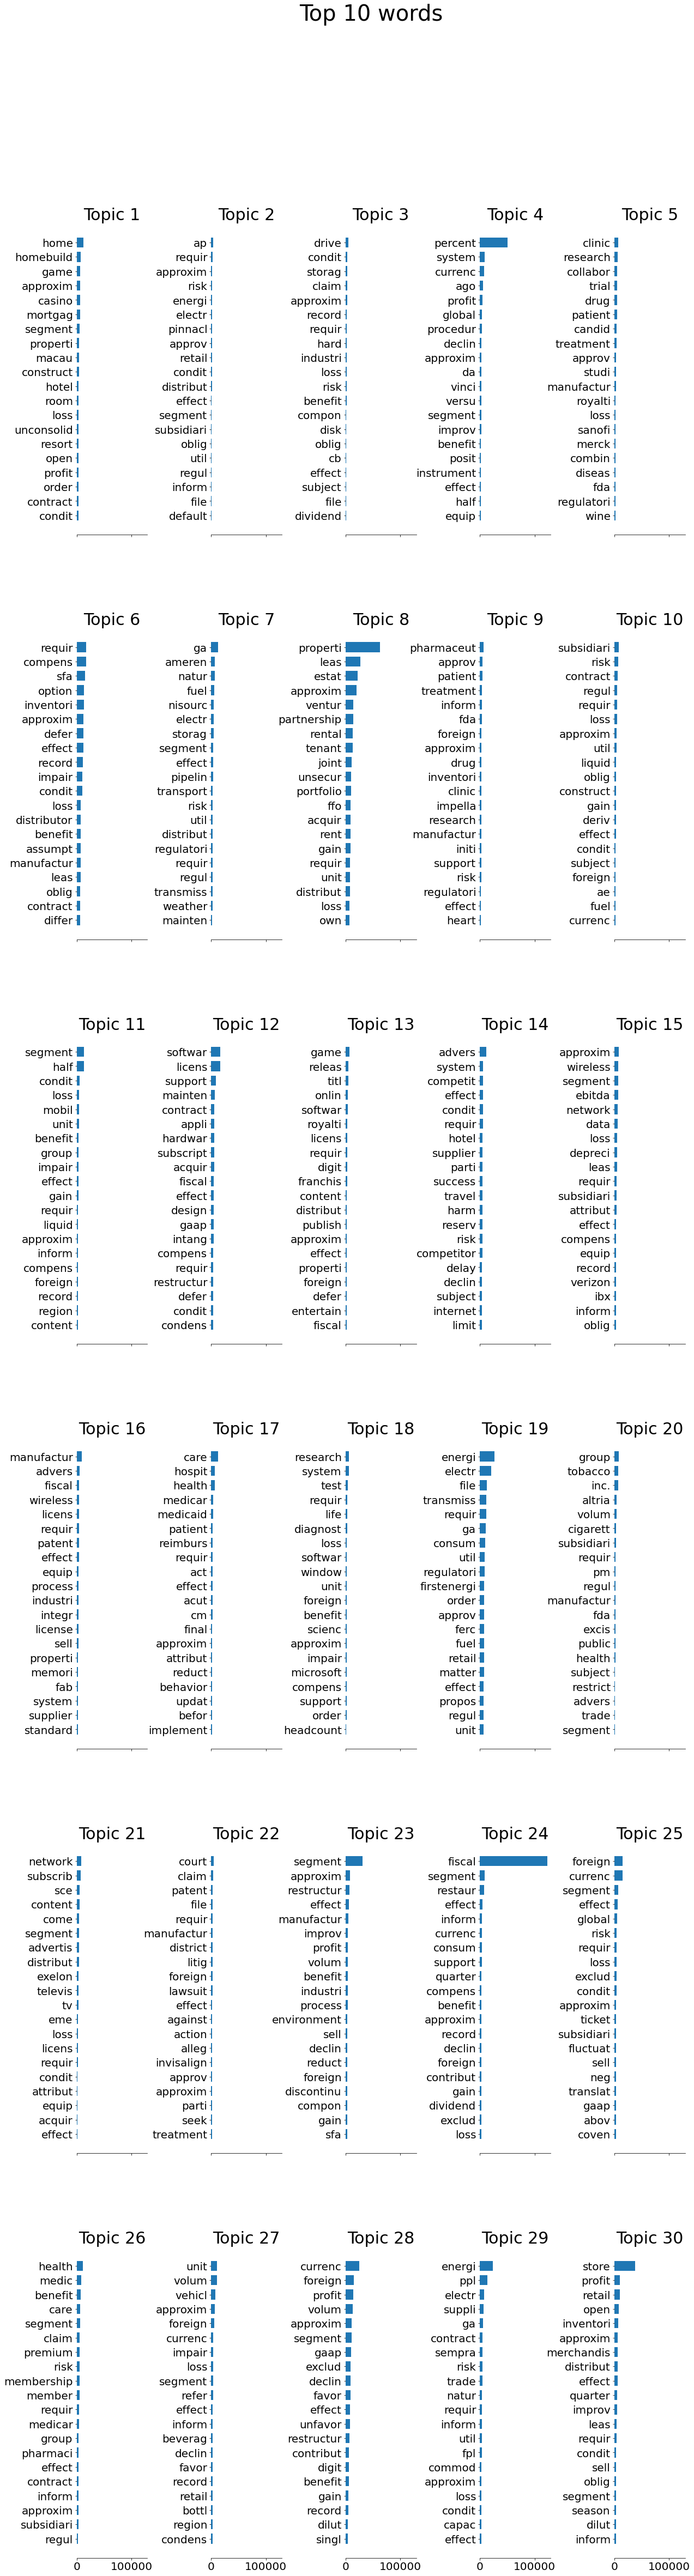

In [ ]:
plot_top_words(unigram_lda, train_unigram_tf.columns, 20, 'Top 10 words')

## Dominant Topics
We will now locate the dominant topic of the LDA 

In [ ]:
def dominant_topic(df, score):
  df = df.copy()
  dominant_topic = np.argmax(score, axis=1).T + 1
  return dominant_topic

In [ ]:
train_set['dominant_topic'] = dominant_topic(train_set, train_unigram_lda_score)

## Excess Return Relationship
First we will plot the excess return by topics

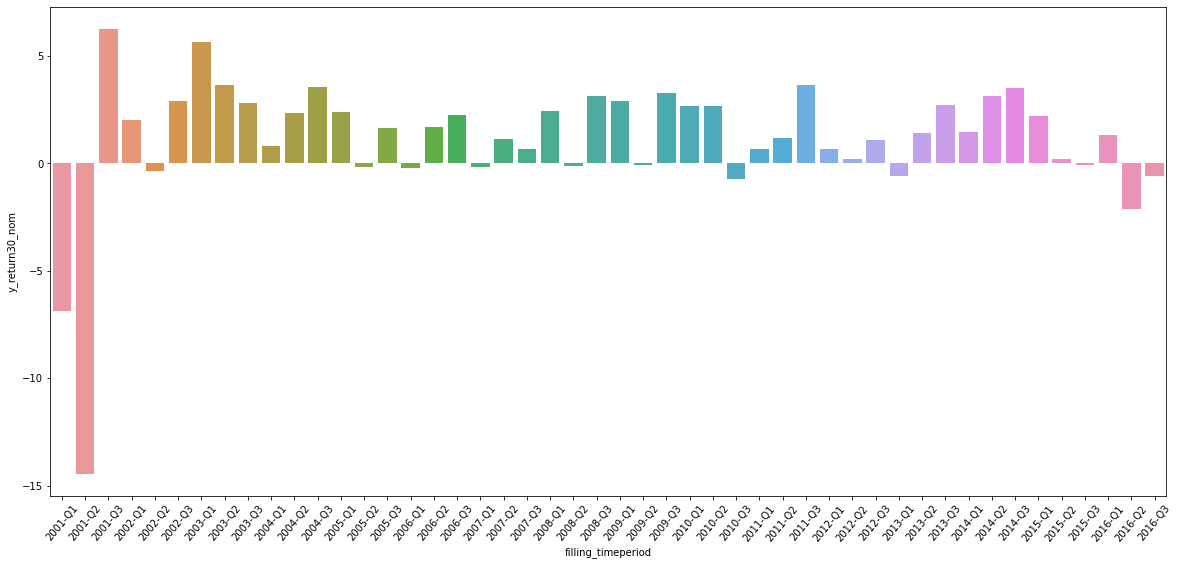

In [ ]:
# set datetime 
train_set['fillingDate'] = pd.to_datetime(train_set['fillingDate'], format='%Y-%m-%d')

train_set['filling_timeperiod'] = train_set['fillingDate'].dt.year.astype(str) + '-' + train_set['period']
train_set['year'] = train_set['fillingDate'].dt.year

# display the average return of each period 
period_returns = train_set.groupby('filling_timeperiod').mean()['y_return30_nom'] * 100

# plot 
fig, ax = plt.subplots(figsize=(20, 9))
g = sns.barplot(data=period_returns.reset_index(), 
                x='filling_timeperiod', 
                y='y_return30_nom', ci=None)
plt.xticks(rotation=50)
plt.savefig(f'{train_dir}/eda_images/returnsByPeriods.png', transparent=False)

The Excess Returns after 90 days by the 10Q dominant topics.

In [ ]:
def plot_topic_to_target(topic_arr, target_arr, title):
  fig, ax = plt.subplots(figsize=(10, 15))
  g = sns.boxplot(y=topic_arr, x=target_arr, orient='h')
  g.set(title=title, ylabel="Dominant Topics", xlabel="Average Return")
  plt.axvline(x=0, c='red')

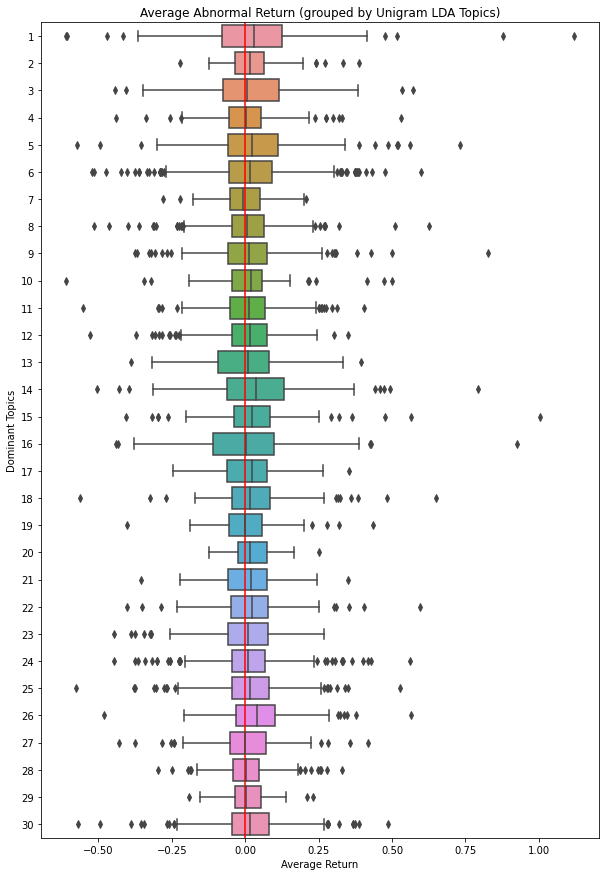

In [ ]:
plot_topic_to_target(train_set['dominant_topic'], train_set['y_return30_nom'], "Average Abnormal Return (grouped by Unigram LDA Topics)")
plt.savefig(f'{train_dir}/eda_images/avgReturnsByTopics.png', transparent=False)

In [ ]:
train_set.groupby('dominant_topic').aggregate(['mean', 'median', 'std'])['y_return30_nom']

mean    median       std
dominant_topic                              
1              -0.002784  0.001216  0.093979
2               0.016596  0.018058  0.118916
3               0.015420  0.017506  0.126041
4               0.022598  0.026489  0.147374
5               0.013524  0.015416  0.114640
6               0.031749  0.023604  0.174128
7               0.005428  0.003297  0.105133
8               0.014542  0.002394  0.081740
9               0.013355  0.017928  0.085715
10              0.017355  0.020927  0.115481
11              0.020111  0.023951  0.138219
12             -0.009262  0.003122  0.095460
13              0.007689  0.007765  0.101401
14              0.028659  0.029150  0.107902
15              0.004457  0.003600  0.089334
16              0.008264  0.011254  0.120194
17              0.015434  0.014815  0.099295
18              0.014000 -0.009747  0.152273
19             -0.001640 -0.001960  0.090778
20              0.035014  0.027128  0.138244
21              0.008384  0.014494  0.119753
22              0.001913  0.001895  0.107306
23              0.016914  0.021306  0.103535
24              0.034937  0.017735  0.164574
25              0.008550  0.006864  0.100589
26              0.001799 -0.001341  0.092668
27              0.026688  0.029096  0.140089
28             -0.001154 -0.006237  0.071881
29              0.016650  0.020489  0.115109
30              0.021405  0.012887  0.145784

Some of the topics has more influence on positive/ negative returns. We could conduct a T-test to find out which topics have significant returns (mean != 0)

In [ ]:
abs(train_set['y_return30_nom']).mean()

0.08589372611735721

In [ ]:
# loop topics
def get_significant_topics(X, y, k, mean=0.00, alpha=0.05):
  significant_topics = []
  significant_results = []

  for topic_id in range(1, k + 1):
    subset = X == topic_id

    if sum(subset) == 0:
      continue 

    _, p = ttest_1samp(y[subset].copy(), mean)

    # print(f"Topic {topic_id} average Return: ", y.mean())
    # print(f"Number of Sample: ", y.count())
    # print(f"P value: ", p)
    # print('\n')

    if p < alpha:
      significant_topics.append(topic_id)
      significant_results.append((y[subset].mean(), p))
  
  return significant_topics, significant_results

In [ ]:
unigram_sign_topics, results = get_significant_topics(train_set['dominant_topic'], train_set['y_return30_nom'], k)
unigram_sign_topics = [f'topic_{i}' for i in unigram_sign_topics]
print("Significant Topics Id: ", unigram_sign_topics)
pd.DataFrame(results, index=unigram_sign_topics, columns=['val', 'p']).to_csv(f'{train_dir}/desc/unigram_topic.csv')

Significant Topics Id:  ['topic_1', 'topic_2', 'topic_5', 'topic_6', 'topic_9', 'topic_11', 'topic_12', 'topic_14', 'topic_15', 'topic_18', 'topic_20', 'topic_24', 'topic_25', 'topic_26', 'topic_30']


## Plotting Returns with Topics
Now we will examine how each significant topics perform w.r.t excess return in each period.

In [ ]:
train_unigram_topics.index = train_set.index
df = train_set.merge(train_unigram_topics, left_index=True, right_index=True)

# display the average return of each period 
def topic_average_returns(df, y_col, significant_topics, k):
  fig, ax = plt.subplots(nrows=len(significant_topics), figsize=(20, 8 * len(significant_topics)))
  for i, topic_id in enumerate(significant_topics):
    summary = df.groupby('filling_timeperiod').mean()
    g = sns.lineplot(data=summary.reset_index(), x='filling_timeperiod', y=y_col, ax=ax[i], alpha=0.5, ci=None, label='average return')
    g2 = g.twinx()
    g2 = sns.lineplot(data=summary.reset_index(), x='filling_timeperiod', y=topic_id, ax=g2, ci=None, label=topic_id.replace('_', ' '), color='red', linestyle='--')
    g.set_xticklabels(summary.index, rotation=50, ha='right')
    g.set(ylabel='Average Abnormal Return', xlabel='Filling Time Periods')
    g.legend(loc='upper left')
    g2.set(ylabel='Topic Score', ylim=(0, None))


    # g.set_xticklabels(g.get_xticklabels(), rotation=50)
  # fig, ax = plt.subplots(nrows=len(significant_topics), figsize=(20, 10 * len(significant_topics)))
  # for i, topic_id in enumerate(significant_topics):
  #   period_returns = df.groupby('filling_timeperiod').mean()
  #   sns.barplot(data=period_returns.reset_index(), 
  #               # x='filling_timeperiod', 
  #               x='year',
  #               y=y_col, ax=ax[i])
    

  #   # plot topics score
  #   g = sns.lineplot(data=period_returns, 
  #               x='year', 
  #               y=topic_id, ax=ax[i], label=topic_id)
  #   g.set_xticklabels(g.get_xticklabels(), rotation=50)

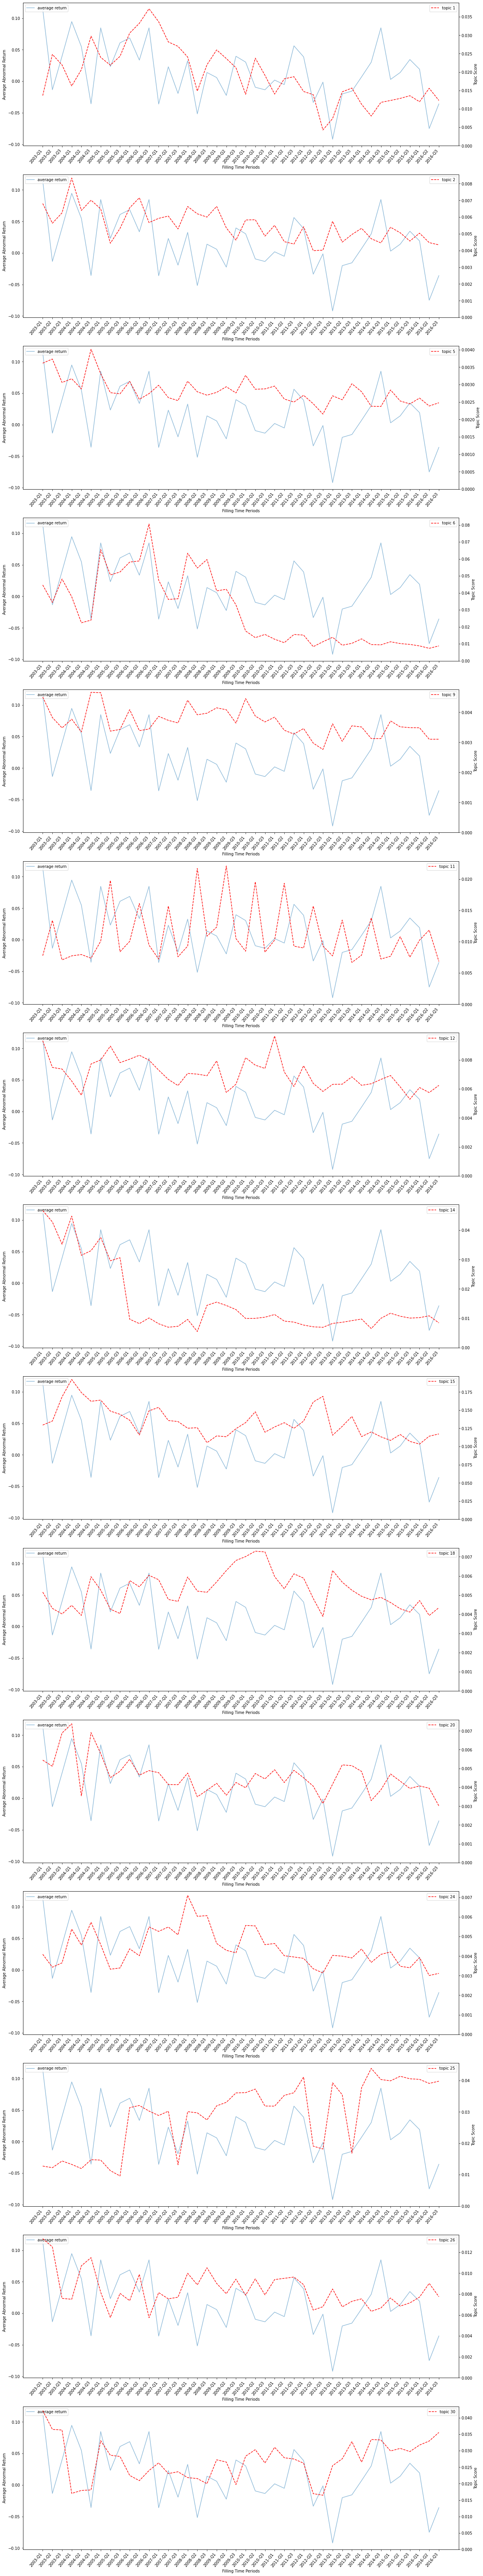

In [ ]:
corr_set = train_set.merge(train_unigram_topics, left_index=True, right_index=True)
corr_set = corr_set[corr_set['fillingDate'].dt.year >= 2003]
corr_set = corr_set[corr_set['GICS Sector'] == 'Real Estate']

topic_average_returns(corr_set, 'y_return30_nom', unigram_sign_topics, k)
# plt.savefig(f'{train_dir}/eda_images/periodReturnsByTopic.png', transparent=False)g



In [ ]:
## Saving a version with only Selected Topics ##
train_selected_topics = train_unigram_topics[unigram_sign_topics]
test_selected_topics = test_unigram_topics[unigram_sign_topics]

# # scaler = MinMaxScaler()
# train_fit = scaler.fit_transform(train_selected_topics)

# train_selected_topics = pd.DataFrame(train_fit, 
#                                      index=train_selected_topics.index, 
#                                      columns=train_selected_topics.columns)

# test_selected_topics = pd.DataFrame(scaler.transform(test_selected_topics), 
#                                      index=test_selected_topics.index, 
#                                      columns=test_selected_topics.columns)

print("[TRAIN]: ", train_selected_topics.shape)
print("[TEST ]: ", test_selected_topics.shape)
# save_to_path(train_selected_topics, test_selected_topics, f'unigram_selectedLda{k}_lg.csv', f'unigram_selectedLda{k}_lg')

[TRAIN]:  (8744, 15)
[TEST ]:  (2291, 15)


# Bigram LDA

In [ ]:
# read the unigram data 
train_unigram_tf = pd.read_csv(datapaths['bigram_tf_lg']['train'], index_col=0)
train_bigram_tf = pd.read_csv(datapaths['bigram_tf_lg']['train'], index_col=0)
test_unigram_tf = pd.read_csv(datapaths['bigram_tf_lg']['test'], index_col=0)
print("[TRAIN] : ", train_unigram_tf.shape)
print("[TEST]  : ", test_unigram_tf.shape)

[TRAIN] :  (8744, 3632)
[TEST]  :  (2291, 3632)


In [ ]:
# build lda 
k = 30
unigram_lda = build_lda(k=k, n_gram_df=train_unigram_tf)

train_unigram_lda_score = unigram_lda.transform(train_unigram_tf)
test_unigram_lda_score = unigram_lda.transform(test_unigram_tf)

In [ ]:
## Saving the topics matrix as features ##
columns_names = [f'topic_{i}' for i in range(1, k + 1)] 
train_unigram_topics = pd.DataFrame(train_unigram_lda_score, columns=columns_names)
test_unigram_topics = pd.DataFrame(test_unigram_lda_score, columns=columns_names)
print("[TRAIN]: ", train_unigram_topics.shape)
print("[TEST ]: ", test_unigram_topics.shape)
save_to_path(train_unigram_topics, test_unigram_topics, f'bigram_lda{k}_lg.csv', f'bigram_lda{k}_lg')

[TRAIN]:  (8744, 30)
[TEST ]:  (2291, 30)


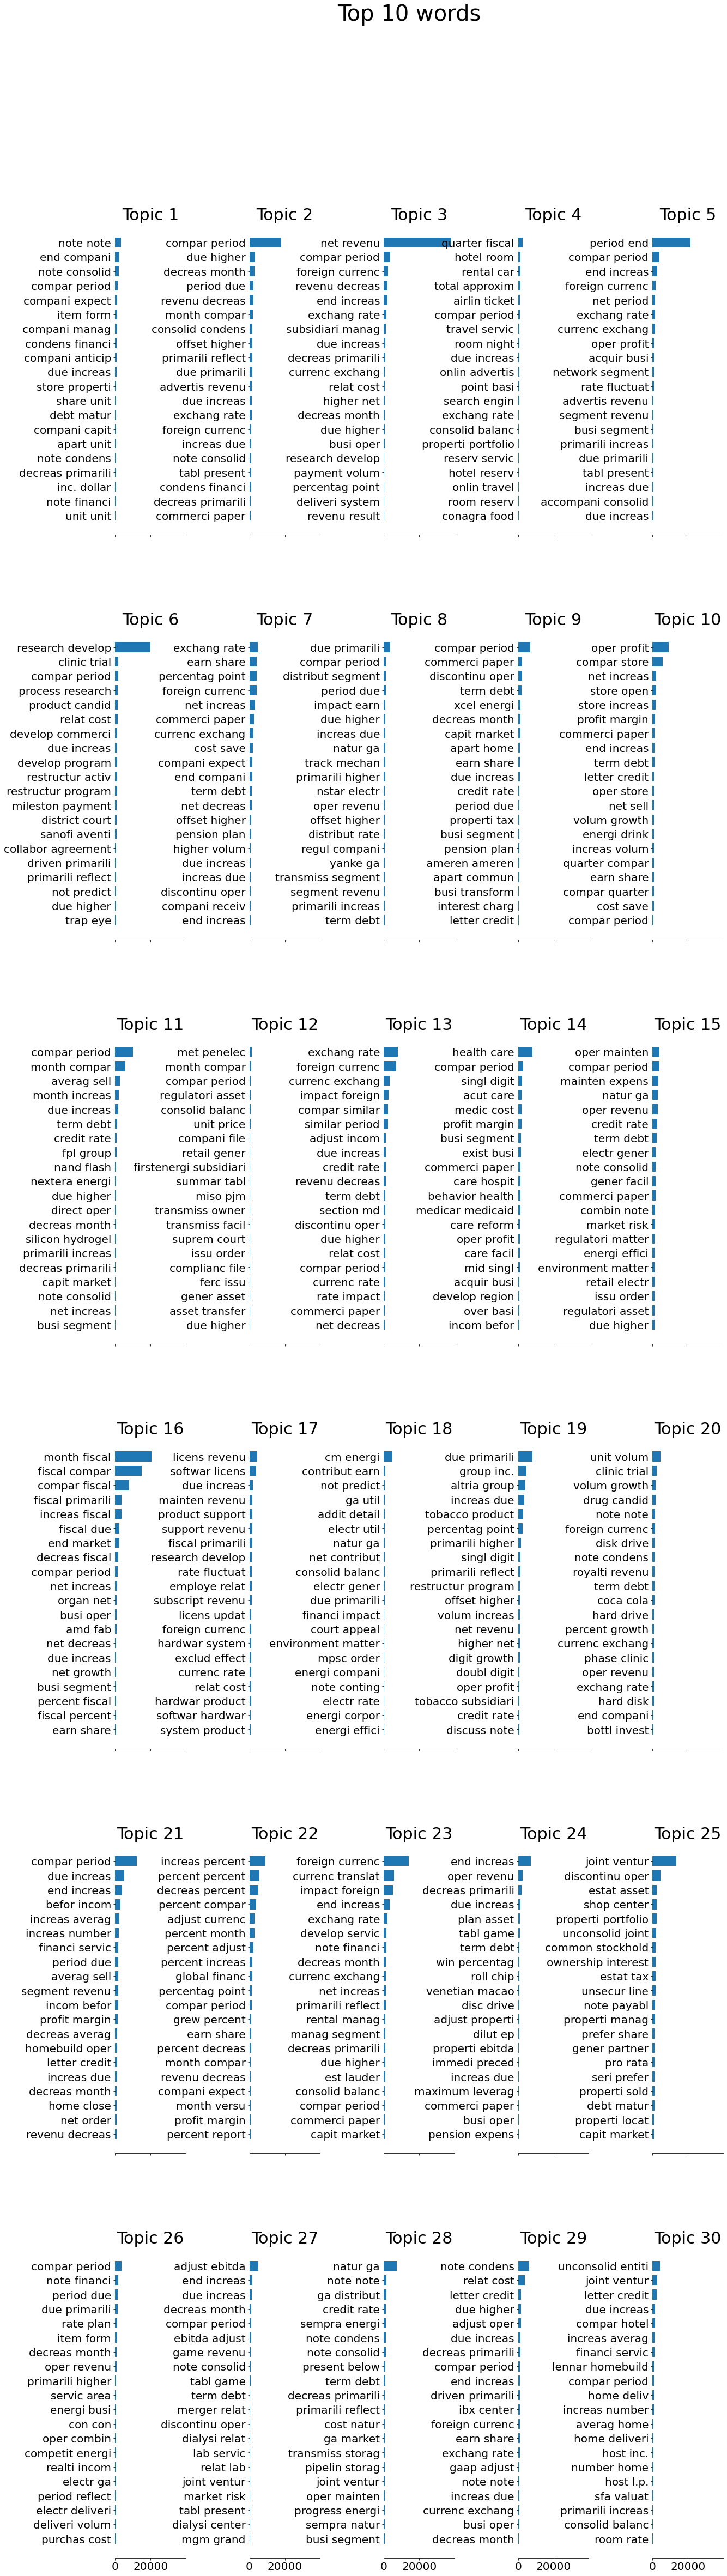

In [ ]:
plot_top_words(unigram_lda, train_unigram_tf.columns, 20, 'Top 10 words')

In [ ]:
train_set['dominant_topic'] = dominant_topic(train_set, train_unigram_lda_score)

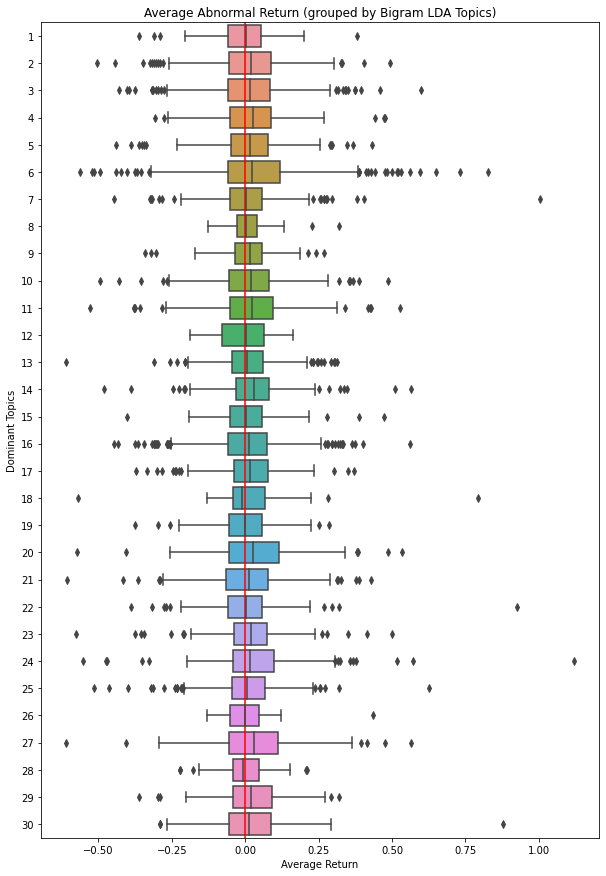

In [ ]:
plot_topic_to_target(train_set['dominant_topic'], train_set['y_return30_nom'], "Average Abnormal Return (grouped by Bigram LDA Topics)")
plt.savefig(f'{train_dir}/eda_images/avgReturnsByBigramTopics.png', transparent=False)

In [ ]:
train_set.groupby('dominant_topic').aggregate(['mean', 'median', 'std'])

netAssets                ...    year          
                        mean        median  ...  median       std
dominant_topic                              ...                  
1               2.173651e+10  5.850668e+09  ...  2010.0  3.989107
2               1.339691e+10  5.329500e+09  ...  2011.0  3.434314
3               7.642770e+09  2.581300e+09  ...  2011.0  4.225578
4               3.891990e+09  4.453000e+09  ...  2012.0  3.933078
5               3.272587e+09  2.087091e+09  ...  2010.0  3.879570
6               6.028268e+09  1.351999e+09  ...  2009.0  4.143258
7               4.553631e+09  2.303400e+09  ...  2010.0  3.759590
8               6.589160e+09  4.037346e+09  ...  2011.0  3.259601
9               4.902312e+09  4.733500e+09  ...  2011.0  3.647731
10              5.076583e+09  2.652000e+09  ...  2010.0  3.771485
11              6.974474e+09  2.842000e+09  ...  2010.0  3.968854
12              9.978937e+09  9.320000e+09  ...  2011.0  3.498619
13              2.019400e+10  4.245050e+09  ...  2012.0  3.471870
14              1.546774e+10  5.791761e+09  ...  2011.0  4.011356
15              1.037047e+10  8.221000e+09  ...  2011.0  3.963795
16              1.116210e+10  3.933000e+09  ...  2009.0  4.154959
17              6.245315e+09  1.528102e+09  ...  2010.0  3.869895
18              4.345967e+09  3.998000e+09  ...  2011.0  3.726915
19              1.943826e+10  1.936500e+10  ...  2011.0  3.903016
20              6.974164e+09  2.108526e+09  ...  2011.0  3.812230
21              6.096509e+09  2.367850e+09  ...  2010.0  3.702759
22              8.313203e+09  5.204800e+09  ...  2009.0  4.059768
23              3.764714e+09  2.188419e+09  ...  2011.0  3.953309
24              6.833274e+09  4.127202e+09  ...  2009.0  3.794786
25              4.312297e+09  3.042466e+09  ...  2010.0  3.978298
26              9.910019e+09  9.961000e+09  ...  2009.0  4.369314
27              3.428050e+09  2.423979e+09  ...  2011.0  3.792699
28              8.445852e+09  7.005500e+09  ...  2011.5  3.214190
29              4.453815e+09  2.125780e+09  ...  2012.5  3.941247
30              4.601818e+09  4.639078e+09  ...  2009.0  3.933624

[30 rows x 234 columns]

In [ ]:
unigram_sign_topics, result = get_significant_topics(train_set['dominant_topic'], train_set['y_return30_nom'], k)
unigram_sign_topics = [f'topic_{i}' for i in unigram_sign_topics]
print("Significant Topics Id: ", unigram_sign_topics)
list(result)

Significant Topics Id:  ['topic_2', 'topic_3', 'topic_5', 'topic_6', 'topic_9', 'topic_10', 'topic_11', 'topic_14', 'topic_17', 'topic_20', 'topic_23', 'topic_24', 'topic_25', 'topic_27']


[(0.01659560890257419, 0.0019093699934916697),
 (0.015419642796561692, 0.0029604663434083414),
 (0.013524062070419188, 0.02581305677102447),
 (0.03174904665460937, 4.7850838249008405e-05),
 (0.013354772893245015, 0.04020880938212346),
 (0.017355080634704947, 0.0009336133224507942),
 (0.0201114687818972, 0.023908623068170258),
 (0.028659326934456168, 6.696108127685387e-06),
 (0.015434144074046748, 0.0033066646435192322),
 (0.03501417137814239, 0.0006841809368941702),
 (0.01691353575395483, 0.002152100835390711),
 (0.03493710880899428, 0.003023743403231412),
 (0.008549714103407526, 0.04572982948307089),
 (0.02668847706901404, 0.002645665510256351)]

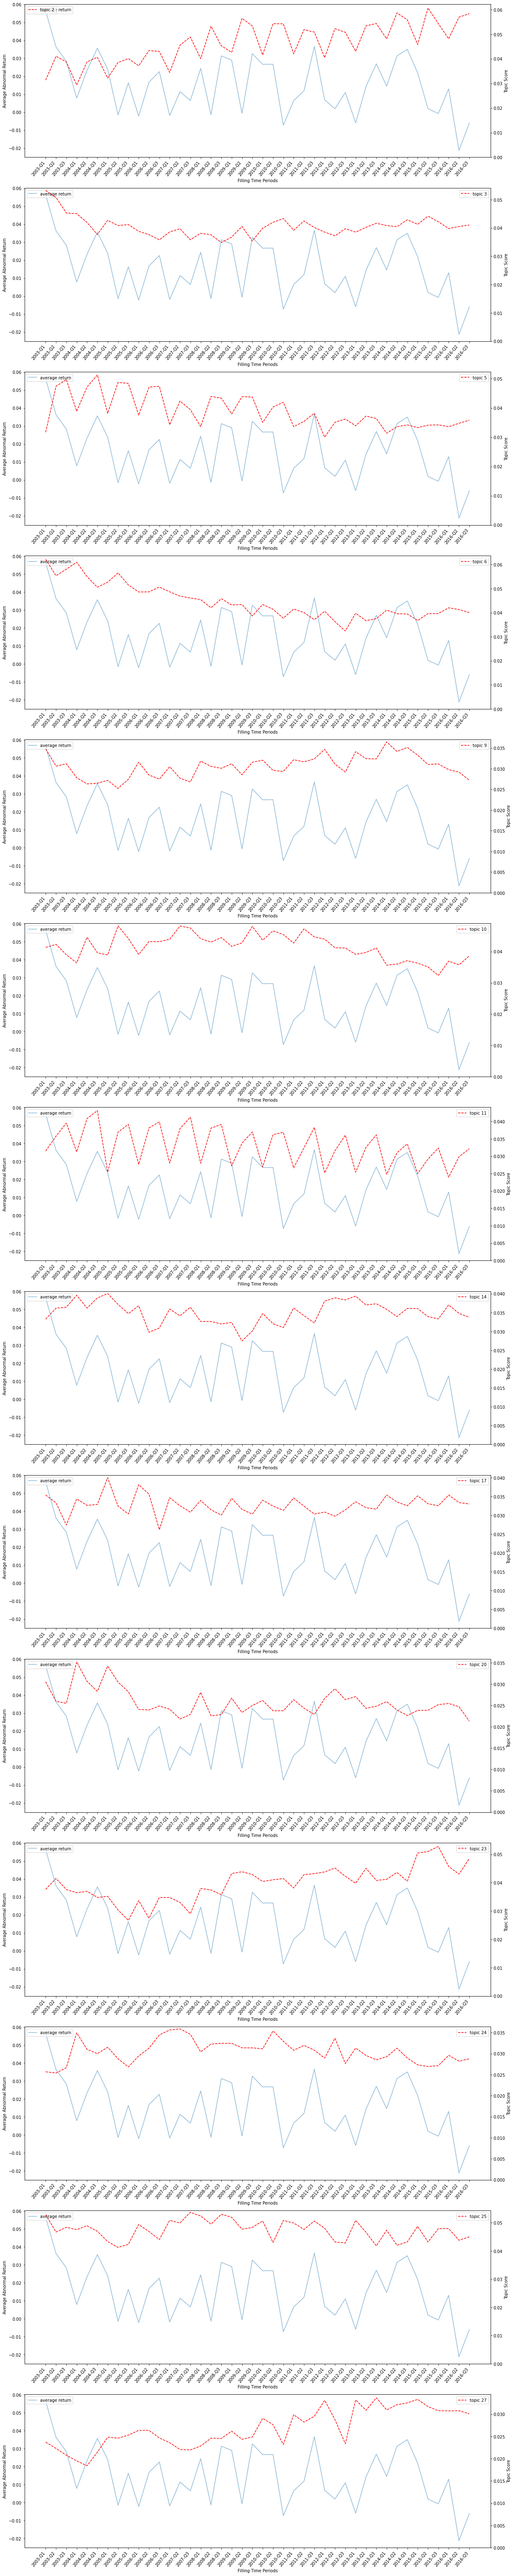

In [ ]:
train_unigram_topics.index = train_set.index
corr_set = train_set.merge(train_unigram_topics, left_index=True, right_index=True)
corr_set = corr_set[corr_set['fillingDate'].dt.year >= 2003]
topic_average_returns(corr_set, 'y_return30_nom', unigram_sign_topics, k)
plt.savefig(f'{train_dir}/eda_images/periodReturnsByBigramTopic.png', transparent=False)

In [ ]:
corr_set.corr()['y_return30_nom'].T.to_csv(f'{train_dir}/desc/bigram_corr.csv')

In [ ]:
## Saving a version with only Selected Topics ##
train_selected_topics = train_unigram_topics[unigram_sign_topics]
test_selected_topics = test_unigram_topics[unigram_sign_topics]

scaler = MinMaxScaler()
train_fit = scaler.fit_transform(train_selected_topics)

train_selected_topics = pd.DataFrame(train_fit, 
                                     index=train_selected_topics.index, 
                                     columns=train_selected_topics.columns)

test_selected_topics = pd.DataFrame(scaler.transform(test_selected_topics), 
                                     index=test_selected_topics.index, 
                                     columns=test_selected_topics.columns)


print("[TRAIN]: ", train_selected_topics.shape)
print("[TEST ]: ", test_selected_topics.shape)
save_to_path(train_selected_topics, test_selected_topics, f'bigram_selectedLda{k}_lg.csv', f'bigram_selectedLda{k}_lg')

[TRAIN]:  (8242, 15)
[TEST ]:  (2291, 15)


## Perplexity Evaluation

In [ ]:
# # we are looking to find out which n_components provide the 
# # the least change in perplexity 
train_unigram_tf = pd.read_csv(datapaths['unigram_tf_lg']['train'], index_col=0)
train_bigram_tf = pd.read_csv(datapaths['bigram_tf_lg']['train'], index_col=0)

test_unigram_tf = pd.read_csv(datapaths['unigram_tf_lg']['test'], index_col=0)
test_bigram_tf = pd.read_csv(datapaths['bigram_tf_lg']['test'], index_col=0)

perplexity = {'unigram': [], 'bigram': [], 'n_topics': list(np.linspace(10, 200, 20, dtype=int))}

for n_gram, train, test in zip(['unigram', 'bigram'], [train_unigram_tf, train_bigram_tf], [test_unigram_tf, test_bigram_tf]):
  for n_topics in perplexity['n_topics']:
    print(f">>>>> Fitting LDA {n_gram}-{n_topics} <<<<<")
    # lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED)
    lda = build_lda(k=n_topics, n_gram_df=train)
    # lda.fit(train)

    # calculate perplexity score
    perplexity_score = lda.perplexity(test)
    perplexity[n_gram].append(perplexity_score)

# perplexity

>>>>> Fitting LDA unigram-10 <<<<<
>>>>> Fitting LDA unigram-20 <<<<<
>>>>> Fitting LDA unigram-30 <<<<<
>>>>> Fitting LDA unigram-40 <<<<<
>>>>> Fitting LDA unigram-50 <<<<<
>>>>> Fitting LDA unigram-60 <<<<<
>>>>> Fitting LDA unigram-70 <<<<<
>>>>> Fitting LDA unigram-80 <<<<<
>>>>> Fitting LDA unigram-90 <<<<<
>>>>> Fitting LDA unigram-100 <<<<<
>>>>> Fitting LDA unigram-110 <<<<<
>>>>> Fitting LDA unigram-120 <<<<<
>>>>> Fitting LDA unigram-130 <<<<<
>>>>> Fitting LDA unigram-140 <<<<<
>>>>> Fitting LDA unigram-150 <<<<<
>>>>> Fitting LDA unigram-160 <<<<<
>>>>> Fitting LDA unigram-170 <<<<<
>>>>> Fitting LDA unigram-180 <<<<<
>>>>> Fitting LDA unigram-190 <<<<<
>>>>> Fitting LDA unigram-200 <<<<<
>>>>> Fitting LDA bigram-10 <<<<<
>>>>> Fitting LDA bigram-20 <<<<<
>>>>> Fitting LDA bigram-30 <<<<<
>>>>> Fitting LDA bigram-40 <<<<<
>>>>> Fitting LDA bigram-50 <<<<<
>>>>> Fitting LDA bigram-60 <<<<<
>>>>> Fitting LDA bigram-70 <<<<<
>>>>> Fitting LDA bigram-80 <<<<<
>>>>> Fitting LDA

Text(0.5, 1.0, 'Perplexity by Number of Topics')

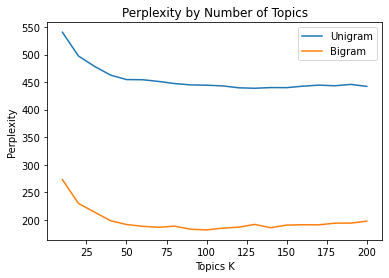

In [ ]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

perplex_df = pd.DataFrame(perplexity)
perplex_df

# plot the perplexity
fig, ax = plt.subplots()
sns.lineplot(data=perplex_df, y='unigram', x='n_topics', ax=ax, label='Unigram')
sns.lineplot(data=perplex_df, y='bigram', x='n_topics', ax=ax, label='Bigram')
plt.ylabel('Perplexity')
plt.xlabel('Topics K')
plt.title('Perplexity by Number of Topics')

# Creating Noun Phrase Vocabs

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
# create a custom analyzer class
class NounPhraseAnalyzer:
    
    # load spaCy's english model and define the tokenizer/lemmatizer
    def __init__(self):
        pass
        
    # allow the class instance to be called just like
    # just like a function and applies the preprocessing and
    # tokenize the document
    def __call__(self, doc):
      doc = nlp(doc)
      nps = []

      for np in doc.noun_chunks:
        # ignore stopwords
        if np.text.lower() in lm_stopwords:
          continue
        
        phrase = []
        for tok in np:
          # ignore stop words 
          if tok.pos_ in ['NUM', 'PUNCT', 'SYM', 'X', 'DET']:
            pass
          else:
            # stem the word 
            tok = porter_stemmer(tok.text)

            # append phrase element 
            phrase.append(tok.strip())
          # tok = porter_stemmer(tok.text)
          # phrase.append(porter_stemmer(tok))

        nps.append(' '.join(phrase).strip()) if phrase else _

      return nps

noun_phrase_analyzer = NounPhraseAnalyzer()
np_tf = ExtendCountVectorizer(
  strip_accents='unicode',
  analyzer=noun_phrase_analyzer, 
  stop_words=None, 
)

Find all the noun phrases using Spacy.

## Create Tokenizer

In [ ]:
# fit a unigram term frequency
text_data = np_tf.fit_transform(train_set['10-q-text'])
print(len(np_tf.vocabulary_))

480974


In [ ]:
len(np_tf.vocabulary_)

480974

## Remove Infrequent Terms

In [ ]:
# retrieve term frequency
# infreq_terms = infrequent_removal(np_tf, text_data, 5)

# retrieve term frequency
matrix_terms = np.array(np_tf.get_feature_names())
matrix_freq = np.asarray(text_data.sum(axis=0)).ravel()
term_freq = dict(zip(matrix_terms, matrix_freq))

# find terms that have <= 15 frequency
infreq_terms = [key for key, val in term_freq.items() if val <= 5]
print("Infrequent Tokens Count: ", len(infreq_terms))
print("Examples: ", random.sample(infreq_terms, 10))

Infrequent Tokens Count:  326944
Examples:  ["inc. 's senior unsecur long term debt", 'advers regulatori decis', 'earn test', 'consolid oper and/or other activ', 'republ china', 'increas profit result', 'stock level', 'limit fund', 'synfuel relat loss reserv', 'small intern acquisit']


In [ ]:
## Perform Chi2 Feature Selection ## 
# set up labels if increase more than 1%
gt_1_pct = abs(train_set['y_return30_nom']) >= 0.01
chi2_kbest = SelectKBest(chi2, k=6000)
kbest = chi2_kbest.fit_transform(text_data, gt_1_pct)

kbest_bool = chi2_kbest.get_support()
vocabs_list = dict(zip(np_tf.get_vocabs().keys(), kbest_bool))
chi2_remove_tokens = [key for key, val in vocabs_list.items() if val == False]
print("Low Chi2 Tokens Count: ", len(chi2_remove_tokens))
print("Examples: ", random.sample(chi2_remove_tokens, 10))

Low Chi2 Tokens Count:  474974
Examples:  ['j.p. morgan secur', 'select catalyt remov technolog', 'unaudit interim consolid balanc sheet', 'certain korean produc', 'benefici foreign exchang impact', 'project pipe', 'storm restor work', 'follow goodwil balanc', 'cocoa and chocol product', 'optim dosag']


In [ ]:
# get the filter out words 
filter_words = set(infreq_terms + chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
np_vocabs = set(np_tf.vocabulary_.keys())
np_vocabs = np_vocabs.difference(filter_words)
print("[TOKENS] ", len(np_vocabs))
print("Examples: ", random.sample(np_vocabs, 10))

[TOKENS]  2854
Examples:  ['non - nuclear gener asset', 'post properti', 'cm erm contract', 'terror coverag', 'IP acquisit', 'subsidiari', 'atria senior live acquisit', 'interseg elimin categori', 'same store sale', 'ltiip']


In [ ]:
# using the filtered vocabs to fit a Tfidf Vectorizer
np_countvectorizer = ExtendCountVectorizer(
  strip_accents='unicode',
  analyzer=noun_phrase_analyzer, 
  stop_words=None, 
  vocabulary=np_vocabs, 
)

# fit the count vectorizer 
np_train_term_freq = np_countvectorizer.fit_transform(train_set['10-q-text'])
np_test_term_freq = np_countvectorizer.transform(test_set['10-q-text'])

np_train_tf_df = pd.DataFrame(np_train_term_freq.toarray(), columns=np_countvectorizer.vocabulary_)
np_test_tf_df = pd.DataFrame(np_test_term_freq.toarray(), columns=np_countvectorizer.vocabulary_)
print("[TRAIN] ", np_train_tf_df.shape)
print("[TEST]  ", np_test_tf_df.shape)
save_to_path(np_train_tf_df, np_test_tf_df, 'np_tf_lg.csv', 'np_tf_lg')

[TRAIN]  (8242, 2854)
[TEST]   (2291, 2854)


## Create LSA from Noun Phrases

In [ ]:
## create pipeline for LSA output ## 
lsa100_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=100, random_state=SEED, n_iter=100))                      
])

lsa200_pipeline = Pipeline([
  ('tfidf', TfidfTransformer()),
  ('svd', TruncatedSVD(n_components=200, random_state=SEED, n_iter=100))                      
])

## fit the training and test data
train_lsa100 = lsa100_pipeline.fit_transform(np_train_term_freq)
test_lsa100 = lsa100_pipeline.transform(np_test_term_freq)

train_lsa200 = lsa200_pipeline.fit_transform(np_train_term_freq)
test_lsa200 = lsa200_pipeline.transform(np_test_term_freq)

In [ ]:
# save to csv
lsa100_columns = [f'lsa_{i}' for i in range(1, 101)]
train_lsa100_df = pd.DataFrame(train_lsa100, columns=lsa100_columns)
test_lsa100_df = pd.DataFrame(test_lsa100, columns=lsa100_columns)
print("[TRAIN] ", train_lsa100_df.shape)
print("[TEST]  ", test_lsa100_df.shape)
save_to_path(train_lsa100_df, test_lsa100_df, 'np_lsa100_lg.csv', 'np_lsa100_lg')


lsa200_columns = [f'lsa_{i}' for i in range(1, 201)]
train_lsa200_df = pd.DataFrame(train_lsa200, columns=lsa200_columns)
test_lsa200_df = pd.DataFrame(test_lsa200, columns=lsa200_columns)
print("[TRAIN] ", train_lsa200_df.shape)
print("[TEST]  ", test_lsa200_df.shape)
save_to_path(train_lsa200_df, test_lsa200_df, 'np_lsa200_lg.csv', 'np_lsa200_lg')

[TRAIN]  (8242, 100)
[TEST]   (2291, 100)
[TRAIN]  (8242, 200)
[TEST]   (2291, 200)


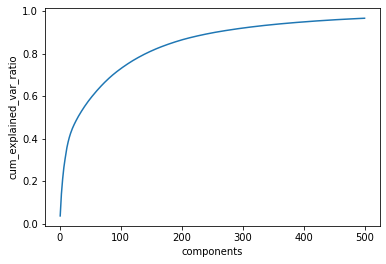

In [ ]:
# plot the data
def plot_lsa_explain_ratio(tf_data, max_components=500):
  tfidf_data = TfidfTransformer().fit_transform(tf_data)
  svd = TruncatedSVD(n_components=max_components, random_state=SEED)
  lsa = svd.fit_transform(tfidf_data)

  # cum_explained_var_ratios = np.cumsum(svd.explained_variance_ratio_)
  df = pd.DataFrame({
    'cum_explained_var_ratio': np.cumsum(svd.explained_variance_ratio_),
    'components': range(1, max_components + 1)
  })
  g = sns.lineplot(data=df, y='cum_explained_var_ratio', x='components')

plot_lsa_explain_ratio(np_train_term_freq)
plt.savefig(f'{train_dir}/eda_images/np_lsa_explainedRatio.png', transparent=False)

# New Vocabs in Test Set

In [ ]:
# fit a unigram term frequency
unigram_tf = ExtendCountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word', 
  stop_words=None, 
  ngram_range=(1, 1), 
  max_df=0.7,
)

text_data = unigram_tf.fit_transform(test_set['10-q-text'])

infreq_terms = infrequent_removal(unigram_tf, text_data, 15)

gt_1_pct = abs(test_set['y_return30_nom']) >= 0.01
chi2_remove_tokens = chi2_feature_selection(unigram_tf, text_data, gt_1_pct)
                                            
# preprocess the LM Sentiment words by stemmer 
sentiment_vocabs_set = set(map(porter_stemmer, sentiment_vocabs_all))

# get the filter out words 
filter_words = set(infreq_terms + chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
unigram_vocabs = set(unigram_tf.vocabulary_.keys())
unigram_vocabs = unigram_vocabs.difference(filter_words)
unigram_vocabs.update(sentiment_vocabs_set)
print("[TEST TOKENS] ", len(unigram_vocabs))

# load train set vocabs
train_vocabs = pd.read_csv(datapaths['unigram_tf_lg']['train'], index_col=0).columns
train_vocabs = set(train_vocabs)
print("[TRAIN TOKENS] ", len(train_vocabs))

# new vocabs 
new_vocabs = unigram_vocabs.difference(train_vocabs)
print("[NEW TOKENS] ", len(new_vocabs))
print("[EXAMPLE] ", random.sample(new_vocabs, 10))

# create term frequency for new vocabs 
unigram_countvectorizer = CountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(1, 1), 
  max_df=0.7,
  vocabulary=new_vocabs
)

unigram_test_term_freq = unigram_countvectorizer.transform(test_set['10-q-text'])
unigram_test_tf_df = pd.DataFrame(unigram_test_term_freq.toarray(), columns=unigram_countvectorizer.vocabulary_, 
                                  index=test_set.index)

# merge with test index 
test_new_vocabs_tf = unigram_test_tf_df.merge(test_set, left_index=True, right_index=True)
test_new_vocabs_tf.head()
test_new_vocabs_tf.to_csv(f'{train_dir}/{datasets}/unigram_new_vocabs_df.csv')

Examples of infrequent Tokens: ['ent', 'almaden', 'colfax', 'presto', 'retrospec', 'cagr', 'malocclus', 'erli', 'unutil', 'nce']
Number of infrequent Tokens  :  7908
Number of Tokens in Sparse Matrix: 14255.
Number of Tokens that have less than 1% return influence 11355
Example of Weak Importance Tokens: ['ividend', 'smartfir', 'salpica', 'osaka', 'constructwar', 'capecitabin', 'wb', 'irrespons', 'dandi', 'sunbeam']
Number of Weak Importance Tokens 11355
[TEST TOKENS]  3641
[TRAIN TOKENS]  5500
[NEW TOKENS]  1083
[EXAMPLE]  ['itcon', 'ngn', 'warehous', 'bidder', 'pure', 'deutsch', 'cobra', 'groundwat', 'switch', 'cwa']


In [ ]:
# fit a bigram term frequency
bigram_tf = ExtendCountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(2, 2), 
  max_df=0.8, 
)

bi_text_data = bigram_tf.fit_transform(test_set['10-q-text'])

matrix_terms = np.array(bigram_tf.get_feature_names())
matrix_freq = np.asarray(bi_text_data.sum(axis=0)).ravel()
term_freq = dict(zip(matrix_terms, matrix_freq))

# find terms that have <= 15 frequency
bi_infreq_terms = [key for key, val in term_freq.items() if val <= 10]

from sklearn.feature_selection import SelectKBest

## Perform Chi2 Feature Selection ## 
# set up labels if increase more than 1%
gt_1_pct = abs(test_set['y_return30_nom']) >= 0.01

chi2_kbest = SelectKBest(chi2, k=6000)
kbest = chi2_kbest.fit_transform(bi_text_data, gt_1_pct)

kbest_bool = chi2_kbest.get_support()
vocabs_list = dict(zip(bigram_tf.get_vocabs().keys(), kbest_bool))
bi_chi2_remove_tokens = [key for key, val in vocabs_list.items() if val == False]

# preprocess the LM Sentiment words by stemmer 
sentiment_vocabs_set = set(map(porter_stemmer, sentiment_vocabs_all))

# get the filter out words 
filter_words = set(bi_infreq_terms + bi_chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
bigram_vocabs = set(bigram_tf.vocabulary_.keys())
bigram_vocabs = bigram_vocabs.difference(filter_words)
# bigram_vocabs.update(sentiment_vocabs_set)
print("[TEST TOKENS] ", len(bigram_vocabs))

# load train set vocabs
train_vocabs = pd.read_csv(datapaths['bigram_tf_lg']['train'], index_col=0).columns
train_vocabs = set(train_vocabs)
print("[TRAIN TOKENS] ", len(train_vocabs))

# new vocabs 
new_vocabs = bigram_vocabs.difference(train_vocabs)
print("[NEW TOKENS] ", len(new_vocabs))
print("[EXAMPLE] ", random.sample(new_vocabs, 10))

# using the filtered vocabs to fit a Tfidf Vectorizer
bigram_countvectorizer = CountVectorizer(
  strip_accents='unicode',
  tokenizer=tokenizer.tokenize,
  analyzer='word',  
  stop_words=None, 
  ngram_range=(2, 2), 
  max_df=0.7,
  vocabulary=new_vocabs
)

unigram_test_term_freq = bigram_countvectorizer.transform(test_set['10-q-text'])
unigram_test_tf_df = pd.DataFrame(unigram_test_term_freq.toarray(), columns=bigram_countvectorizer.vocabulary_, 
                                  index=test_set.index)

# merge with test index 
test_new_vocabs_tf = unigram_test_tf_df.merge(test_set, left_index=True, right_index=True)
test_new_vocabs_tf.head()
test_new_vocabs_tf.to_csv(f'{train_dir}/{datasets}/bigram_new_vocabs_df.csv')

[TRAIN TOKENS]  3632
[NEW TOKENS]  2567
[EXAMPLE]  ['compar consist', 'acxiom acquisit', 'recov highest', 'class develop', 'offshor wind', 'valv system', 'fix versu', 'electr margin', 'registr access', 'improv effort']


In [ ]:
text_data = np_tf.fit_transform(test_set['10-q-text'])

# retrieve term frequency
matrix_terms = np.array(np_tf.get_feature_names())
matrix_freq = np.asarray(text_data.sum(axis=0)).ravel()
term_freq = dict(zip(matrix_terms, matrix_freq))

# find terms that have <= 15 frequency
infreq_terms = [key for key, val in term_freq.items() if val <= 5]

gt_1_pct = abs(test_set['y_return30_nom']) >= 0.01
chi2_kbest = SelectKBest(chi2, k=6000)
kbest = chi2_kbest.fit_transform(text_data, gt_1_pct)

kbest_bool = chi2_kbest.get_support()
vocabs_list = dict(zip(np_tf.get_vocabs().keys(), kbest_bool))
chi2_remove_tokens = [key for key, val in vocabs_list.items() if val == False]

# get the filter out words 
filter_words = set(infreq_terms + chi2_remove_tokens)

# get the vocabs -> remove filtered -> update sentiment words 
np_vocabs = set(np_tf.vocabulary_.keys())
np_vocabs = np_vocabs.difference(filter_words)
print("[TEST TOKENS] ", len(np_vocabs))
print("Examples: ", random.sample(np_vocabs, 10))

# load train set vocabs
train_vocabs = pd.read_csv(datapaths['np_tf_lg']['train'], index_col=0).columns
train_vocabs = set(train_vocabs)
print("[TRAIN TOKENS] ", len(train_vocabs))

# new vocabs 
new_vocabs = np_vocabs.difference(train_vocabs)
print("[NEW TOKENS] ", len(new_vocabs))
print("[EXAMPLE] ", random.sample(new_vocabs, 10))


# using the filtered vocabs to fit a Tfidf Vectorizer
np_countvectorizer = ExtendCountVectorizer(
  strip_accents='unicode',
  analyzer=noun_phrase_analyzer, 
  stop_words=None, 
  vocabulary=new_vocabs, 
)

unigram_test_term_freq = np_countvectorizer.transform(test_set['10-q-text'])
unigram_test_tf_df = pd.DataFrame(unigram_test_term_freq.toarray(), columns=np_countvectorizer.vocabulary_, 
                                  index=test_set.index)

# merge with test index 
test_new_vocabs_tf = unigram_test_tf_df.merge(test_set, left_index=True, right_index=True)
test_new_vocabs_tf.head()
test_new_vocabs_tf.to_csv(f'{train_dir}/{datasets}/np_new_vocabs_df.csv')

[NEW TOKENS]  3200
[EXAMPLE]  ['adjust properti ebitda margin', 'signific valu', 'check out', 'fuel price spread', 'hurrican florenc', 'revenu net revenu', 'end user', 'industri sale', 'bridg commit letter', 'infrareit merger agreement']
